<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[15:13:06] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


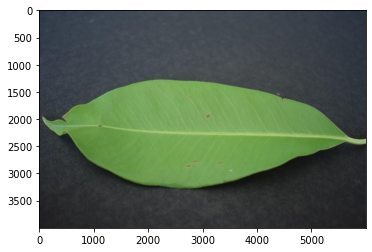

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

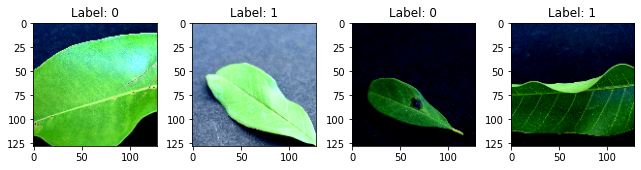

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[15:13:14] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[15:13:16] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2893745057890456 samples/sec                   batch loss = 0.4508569836616516 | accuracy = 0.5


Epoch[1] Batch[10] Speed: 1.2950652912303973 samples/sec                   batch loss = 0.8668118119239807 | accuracy = 0.525


Epoch[1] Batch[15] Speed: 1.3072082055808354 samples/sec                   batch loss = 0.9100776314735413 | accuracy = 0.55


Epoch[1] Batch[20] Speed: 1.2728690510241165 samples/sec                   batch loss = 0.5154880285263062 | accuracy = 0.575


Epoch[1] Batch[25] Speed: 1.298325957262201 samples/sec                   batch loss = 0.8065424561500549 | accuracy = 0.55


Epoch[1] Batch[30] Speed: 1.297786141644916 samples/sec                   batch loss = 0.3395019471645355 | accuracy = 0.5416666666666666


Epoch[1] Batch[35] Speed: 1.2938307578255626 samples/sec                   batch loss = 0.5646322965621948 | accuracy = 0.55


Epoch[1] Batch[40] Speed: 1.306876761324237 samples/sec                   batch loss = 0.415058434009552 | accuracy = 0.5625


Epoch[1] Batch[45] Speed: 1.300954002559071 samples/sec                   batch loss = 0.7222937941551208 | accuracy = 0.5555555555555556


Epoch[1] Batch[50] Speed: 1.2995667727587603 samples/sec                   batch loss = 0.7007706165313721 | accuracy = 0.565


Epoch[1] Batch[55] Speed: 1.3021026237996336 samples/sec                   batch loss = 0.6393948197364807 | accuracy = 0.5681818181818182


Epoch[1] Batch[60] Speed: 1.3053056330250132 samples/sec                   batch loss = 0.7958783507347107 | accuracy = 0.5791666666666667


Epoch[1] Batch[65] Speed: 1.3058566023367193 samples/sec                   batch loss = 0.46560755372047424 | accuracy = 0.5807692307692308


Epoch[1] Batch[70] Speed: 1.3000947723332978 samples/sec                   batch loss = 0.5805787444114685 | accuracy = 0.5964285714285714


Epoch[1] Batch[75] Speed: 1.3090451381072825 samples/sec                   batch loss = 0.6099343299865723 | accuracy = 0.6066666666666667


Epoch[1] Batch[80] Speed: 1.3068370603843331 samples/sec                   batch loss = 2.838406562805176 | accuracy = 0.61875


Epoch[1] Batch[85] Speed: 1.3008137948220415 samples/sec                   batch loss = 0.5383477210998535 | accuracy = 0.6264705882352941


Epoch[1] Batch[90] Speed: 1.3000260668259191 samples/sec                   batch loss = 0.3183848261833191 | accuracy = 0.6416666666666667


Epoch[1] Batch[95] Speed: 1.302643205052672 samples/sec                   batch loss = 0.35175976157188416 | accuracy = 0.6447368421052632


Epoch[1] Batch[100] Speed: 1.300980030054679 samples/sec                   batch loss = 0.4935079514980316 | accuracy = 0.6525


Epoch[1] Batch[105] Speed: 1.2966093449111888 samples/sec                   batch loss = 2.602477788925171 | accuracy = 0.6571428571428571


Epoch[1] Batch[110] Speed: 1.302694890608659 samples/sec                   batch loss = 0.6205063462257385 | accuracy = 0.6613636363636364


Epoch[1] Batch[115] Speed: 1.2990562006273825 samples/sec                   batch loss = 0.5078005194664001 | accuracy = 0.6630434782608695


Epoch[1] Batch[120] Speed: 1.3001343669282686 samples/sec                   batch loss = 0.3291749358177185 | accuracy = 0.6625


Epoch[1] Batch[125] Speed: 1.3015929859339463 samples/sec                   batch loss = 0.8123288154602051 | accuracy = 0.666


Epoch[1] Batch[130] Speed: 1.3085149478573996 samples/sec                   batch loss = 0.9414113759994507 | accuracy = 0.6673076923076923


Epoch[1] Batch[135] Speed: 1.3139412089951772 samples/sec                   batch loss = 0.6761132478713989 | accuracy = 0.6648148148148149


Epoch[1] Batch[140] Speed: 1.3047191075546907 samples/sec                   batch loss = 0.38241955637931824 | accuracy = 0.6660714285714285


Epoch[1] Batch[145] Speed: 1.3020110717243885 samples/sec                   batch loss = 0.28521817922592163 | accuracy = 0.6672413793103448


Epoch[1] Batch[150] Speed: 1.3090859947704339 samples/sec                   batch loss = 0.5194627642631531 | accuracy = 0.665


Epoch[1] Batch[155] Speed: 1.3084004513248857 samples/sec                   batch loss = 0.6772544980049133 | accuracy = 0.6612903225806451


Epoch[1] Batch[160] Speed: 1.3119269728149898 samples/sec                   batch loss = 0.5329189300537109 | accuracy = 0.6625


Epoch[1] Batch[165] Speed: 1.3123374559144145 samples/sec                   batch loss = 0.40668532252311707 | accuracy = 0.6606060606060606


Epoch[1] Batch[170] Speed: 1.303767760275189 samples/sec                   batch loss = 0.9466826915740967 | accuracy = 0.6558823529411765


Epoch[1] Batch[175] Speed: 1.3080781930181475 samples/sec                   batch loss = 0.5012222528457642 | accuracy = 0.6585714285714286


Epoch[1] Batch[180] Speed: 1.3060904196538972 samples/sec                   batch loss = 0.26637744903564453 | accuracy = 0.6652777777777777


Epoch[1] Batch[185] Speed: 1.3083922883445172 samples/sec                   batch loss = 0.7360799312591553 | accuracy = 0.6635135135135135


Epoch[1] Batch[190] Speed: 1.3044719868305774 samples/sec                   batch loss = 1.0859390497207642 | accuracy = 0.6631578947368421


Epoch[1] Batch[195] Speed: 1.3071934372051899 samples/sec                   batch loss = 0.4934879243373871 | accuracy = 0.6653846153846154


Epoch[1] Batch[200] Speed: 1.3058538580218806 samples/sec                   batch loss = 0.8335704803466797 | accuracy = 0.66375


Epoch[1] Batch[205] Speed: 1.3042244527625655 samples/sec                   batch loss = 0.44440215826034546 | accuracy = 0.6634146341463415


Epoch[1] Batch[210] Speed: 1.306772322487037 samples/sec                   batch loss = 0.9028492569923401 | accuracy = 0.6678571428571428


Epoch[1] Batch[215] Speed: 1.3085611807457962 samples/sec                   batch loss = 0.9425610303878784 | accuracy = 0.6662790697674419


Epoch[1] Batch[220] Speed: 1.3015121068856839 samples/sec                   batch loss = 0.2812580466270447 | accuracy = 0.6681818181818182


Epoch[1] Batch[225] Speed: 1.3053312255764133 samples/sec                   batch loss = 0.6537832617759705 | accuracy = 0.6677777777777778


Epoch[1] Batch[230] Speed: 1.2982659778988868 samples/sec                   batch loss = 0.35281801223754883 | accuracy = 0.6663043478260869


Epoch[1] Batch[235] Speed: 1.30418085755803 samples/sec                   batch loss = 0.6387993693351746 | accuracy = 0.6670212765957447


Epoch[1] Batch[240] Speed: 1.2981998764106726 samples/sec                   batch loss = 0.3568929135799408 | accuracy = 0.6697916666666667


Epoch[1] Batch[245] Speed: 1.2980708070442626 samples/sec                   batch loss = 0.29746121168136597 | accuracy = 0.6704081632653062


Epoch[1] Batch[250] Speed: 1.3039079975232517 samples/sec                   batch loss = 0.3321555554866791 | accuracy = 0.672


Epoch[1] Batch[255] Speed: 1.3009018498203093 samples/sec                   batch loss = 0.4072388708591461 | accuracy = 0.6745098039215687


Epoch[1] Batch[260] Speed: 1.3071196003321164 samples/sec                   batch loss = 0.19701474905014038 | accuracy = 0.6778846153846154


Epoch[1] Batch[265] Speed: 1.3027420281748017 samples/sec                   batch loss = 0.7565654516220093 | accuracy = 0.6811320754716981


Epoch[1] Batch[270] Speed: 1.2988188618864007 samples/sec                   batch loss = 0.49887216091156006 | accuracy = 0.6842592592592592


Epoch[1] Batch[275] Speed: 1.3019252912319017 samples/sec                   batch loss = 0.3868308961391449 | accuracy = 0.6836363636363636


Epoch[1] Batch[280] Speed: 1.298720029849198 samples/sec                   batch loss = 0.4370012581348419 | accuracy = 0.6848214285714286


Epoch[1] Batch[285] Speed: 1.3013336229113057 samples/sec                   batch loss = 0.22363251447677612 | accuracy = 0.6859649122807018


Epoch[1] Batch[290] Speed: 1.300876834129755 samples/sec                   batch loss = 0.8774679899215698 | accuracy = 0.6879310344827586


Epoch[1] Batch[295] Speed: 1.303643051478513 samples/sec                   batch loss = 0.09983696788549423 | accuracy = 0.6872881355932203


Epoch[1] Batch[300] Speed: 1.2984084504971223 samples/sec                   batch loss = 0.5830504298210144 | accuracy = 0.6916666666666667


Epoch[1] Batch[305] Speed: 1.3024604672975773 samples/sec                   batch loss = 0.8087173104286194 | accuracy = 0.690983606557377


Epoch[1] Batch[310] Speed: 1.2994149880868484 samples/sec                   batch loss = 0.7042666673660278 | accuracy = 0.6903225806451613


Epoch[1] Batch[315] Speed: 1.3002209192366825 samples/sec                   batch loss = 0.3474672734737396 | accuracy = 0.6888888888888889


Epoch[1] Batch[320] Speed: 1.297565624366046 samples/sec                   batch loss = 0.7828757762908936 | accuracy = 0.68984375


Epoch[1] Batch[325] Speed: 1.299274306908384 samples/sec                   batch loss = 0.6699308156967163 | accuracy = 0.69


Epoch[1] Batch[330] Speed: 1.3034804897269392 samples/sec                   batch loss = 0.4337380826473236 | accuracy = 0.6901515151515152


Epoch[1] Batch[335] Speed: 1.3024358971771266 samples/sec                   batch loss = 0.21716687083244324 | accuracy = 0.6895522388059702


Epoch[1] Batch[340] Speed: 1.299662511962675 samples/sec                   batch loss = 1.8315885066986084 | accuracy = 0.6897058823529412


Epoch[1] Batch[345] Speed: 1.3053669755821635 samples/sec                   batch loss = 0.656886637210846 | accuracy = 0.6891304347826087


Epoch[1] Batch[350] Speed: 1.3060399893600019 samples/sec                   batch loss = 0.1308530569076538 | accuracy = 0.69


Epoch[1] Batch[355] Speed: 1.3039149899096916 samples/sec                   batch loss = 0.3783751130104065 | accuracy = 0.6915492957746479


Epoch[1] Batch[360] Speed: 1.2998176776802013 samples/sec                   batch loss = 0.36134910583496094 | accuracy = 0.6923611111111111


Epoch[1] Batch[365] Speed: 1.3003105064619802 samples/sec                   batch loss = 0.41867882013320923 | accuracy = 0.6931506849315069


Epoch[1] Batch[370] Speed: 1.301250152018684 samples/sec                   batch loss = 0.8996633291244507 | accuracy = 0.6912162162162162


Epoch[1] Batch[375] Speed: 1.299943972260574 samples/sec                   batch loss = 0.21416853368282318 | accuracy = 0.6906666666666667


Epoch[1] Batch[380] Speed: 1.2904782438337903 samples/sec                   batch loss = 0.40397050976753235 | accuracy = 0.6914473684210526


Epoch[1] Batch[385] Speed: 1.2885467281687573 samples/sec                   batch loss = 1.5504428148269653 | accuracy = 0.6896103896103896


Epoch[1] Batch[390] Speed: 1.2973262216511734 samples/sec                   batch loss = 0.42906472086906433 | accuracy = 0.6891025641025641


Epoch[1] Batch[395] Speed: 1.2965650548956118 samples/sec                   batch loss = 0.9857825040817261 | accuracy = 0.6892405063291139


Epoch[1] Batch[400] Speed: 1.3081797805901119 samples/sec                   batch loss = 0.6135275363922119 | accuracy = 0.69


Epoch[1] Batch[405] Speed: 1.2975290961952655 samples/sec                   batch loss = 0.40604203939437866 | accuracy = 0.691358024691358


Epoch[1] Batch[410] Speed: 1.3033821620809471 samples/sec                   batch loss = 0.5040012001991272 | accuracy = 0.6920731707317073


Epoch[1] Batch[415] Speed: 1.3017014462766636 samples/sec                   batch loss = 0.2910759449005127 | accuracy = 0.6939759036144578


Epoch[1] Batch[420] Speed: 1.3001243924900785 samples/sec                   batch loss = 0.5024845600128174 | accuracy = 0.6952380952380952


Epoch[1] Batch[425] Speed: 1.299996451149138 samples/sec                   batch loss = 0.7270975708961487 | accuracy = 0.6964705882352941


Epoch[1] Batch[430] Speed: 1.302910375566827 samples/sec                   batch loss = 1.5807886123657227 | accuracy = 0.6941860465116279


Epoch[1] Batch[435] Speed: 1.300447178472121 samples/sec                   batch loss = 0.8246906995773315 | accuracy = 0.6948275862068966


Epoch[1] Batch[440] Speed: 1.294448878723267 samples/sec                   batch loss = 0.24604220688343048 | accuracy = 0.6960227272727273


Epoch[1] Batch[445] Speed: 1.3008849036022347 samples/sec                   batch loss = 0.7826842069625854 | accuracy = 0.6949438202247191


Epoch[1] Batch[450] Speed: 1.301856594159793 samples/sec                   batch loss = 0.47070252895355225 | accuracy = 0.6927777777777778


Epoch[1] Batch[455] Speed: 1.3001350721973681 samples/sec                   batch loss = 0.8268309235572815 | accuracy = 0.6912087912087912


Epoch[1] Batch[460] Speed: 1.3029687609941671 samples/sec                   batch loss = 0.7487019300460815 | accuracy = 0.691304347826087


Epoch[1] Batch[465] Speed: 1.2984128718677943 samples/sec                   batch loss = 0.38701367378234863 | accuracy = 0.6924731182795699


Epoch[1] Batch[470] Speed: 1.2991055900544166 samples/sec                   batch loss = 0.8244042992591858 | accuracy = 0.6925531914893617


Epoch[1] Batch[475] Speed: 1.304167475428727 samples/sec                   batch loss = 1.0691410303115845 | accuracy = 0.6931578947368421


Epoch[1] Batch[480] Speed: 1.3047833377494382 samples/sec                   batch loss = 0.6599015593528748 | accuracy = 0.6942708333333333


Epoch[1] Batch[485] Speed: 1.3014281083287456 samples/sec                   batch loss = 0.43158257007598877 | accuracy = 0.6948453608247422


Epoch[1] Batch[490] Speed: 1.3038881355012761 samples/sec                   batch loss = 0.36489394307136536 | accuracy = 0.6964285714285714


Epoch[1] Batch[495] Speed: 1.2988279113494978 samples/sec                   batch loss = 0.50232994556427 | accuracy = 0.6964646464646465


Epoch[1] Batch[500] Speed: 1.308510151254713 samples/sec                   batch loss = 0.23262903094291687 | accuracy = 0.698


Epoch[1] Batch[505] Speed: 1.3038790153877815 samples/sec                   batch loss = 0.601467490196228 | accuracy = 0.6985148514851485


Epoch[1] Batch[510] Speed: 1.30371649609469 samples/sec                   batch loss = 0.7159024477005005 | accuracy = 0.6965686274509804


Epoch[1] Batch[515] Speed: 1.3058567039782312 samples/sec                   batch loss = 0.8232045769691467 | accuracy = 0.6966019417475728


Epoch[1] Batch[520] Speed: 1.2981931460896121 samples/sec                   batch loss = 0.284984827041626 | accuracy = 0.6971153846153846


Epoch[1] Batch[525] Speed: 1.301586422340543 samples/sec                   batch loss = 0.3880726099014282 | accuracy = 0.6980952380952381


Epoch[1] Batch[530] Speed: 1.3062748894251024 samples/sec                   batch loss = 0.5754646062850952 | accuracy = 0.6981132075471698


Epoch[1] Batch[535] Speed: 1.3084714735521676 samples/sec                   batch loss = 0.5417937636375427 | accuracy = 0.6985981308411215


Epoch[1] Batch[540] Speed: 1.3074352731629395 samples/sec                   batch loss = 0.5114879012107849 | accuracy = 0.6995370370370371


Epoch[1] Batch[545] Speed: 1.3057332212094668 samples/sec                   batch loss = 0.34745877981185913 | accuracy = 0.7009174311926606


Epoch[1] Batch[550] Speed: 1.3019676243614509 samples/sec                   batch loss = 0.6529189944267273 | accuracy = 0.7013636363636364


Epoch[1] Batch[555] Speed: 1.3053430066119824 samples/sec                   batch loss = 0.7053870558738708 | accuracy = 0.7009009009009008


Epoch[1] Batch[560] Speed: 1.3027446582682376 samples/sec                   batch loss = 1.072946548461914 | accuracy = 0.7


Epoch[1] Batch[565] Speed: 1.2967606752591188 samples/sec                   batch loss = 0.36119741201400757 | accuracy = 0.7008849557522124


Epoch[1] Batch[570] Speed: 1.3041593651809869 samples/sec                   batch loss = 0.9328925609588623 | accuracy = 0.7004385964912281


Epoch[1] Batch[575] Speed: 1.3033960343926803 samples/sec                   batch loss = 0.5021271109580994 | accuracy = 0.6995652173913044


Epoch[1] Batch[580] Speed: 1.3061205170074912 samples/sec                   batch loss = 1.0694948434829712 | accuracy = 0.7


Epoch[1] Batch[585] Speed: 1.3084260633369262 samples/sec                   batch loss = 0.9671602249145508 | accuracy = 0.7


Epoch[1] Batch[590] Speed: 1.3012379401258316 samples/sec                   batch loss = 0.2975254952907562 | accuracy = 0.7


Epoch[1] Batch[595] Speed: 1.3047016558929263 samples/sec                   batch loss = 0.5009682774543762 | accuracy = 0.7008403361344537


Epoch[1] Batch[600] Speed: 1.302740713132066 samples/sec                   batch loss = 0.797652006149292 | accuracy = 0.7008333333333333


Epoch[1] Batch[605] Speed: 1.3002880329159217 samples/sec                   batch loss = 0.7688817381858826 | accuracy = 0.6995867768595041


Epoch[1] Batch[610] Speed: 1.299853428440337 samples/sec                   batch loss = 0.5641950964927673 | accuracy = 0.6987704918032787


Epoch[1] Batch[615] Speed: 1.3017376037411847 samples/sec                   batch loss = 1.0377488136291504 | accuracy = 0.697560975609756


Epoch[1] Batch[620] Speed: 1.2987837712720811 samples/sec                   batch loss = 0.5786405801773071 | accuracy = 0.6967741935483871


Epoch[1] Batch[625] Speed: 1.2957313242200554 samples/sec                   batch loss = 0.6294995546340942 | accuracy = 0.698


Epoch[1] Batch[630] Speed: 1.3025148686403845 samples/sec                   batch loss = 0.23624524474143982 | accuracy = 0.698015873015873


Epoch[1] Batch[635] Speed: 1.302707837926503 samples/sec                   batch loss = 0.5056957006454468 | accuracy = 0.6980314960629921


Epoch[1] Batch[640] Speed: 1.2988117229544927 samples/sec                   batch loss = 0.26206809282302856 | accuracy = 0.698046875


Epoch[1] Batch[645] Speed: 1.3026283373646717 samples/sec                   batch loss = 0.7253946661949158 | accuracy = 0.6980620155038759


Epoch[1] Batch[650] Speed: 1.2986098543844953 samples/sec                   batch loss = 0.6382823586463928 | accuracy = 0.6984615384615385


Epoch[1] Batch[655] Speed: 1.2946165879170468 samples/sec                   batch loss = 0.6979529857635498 | accuracy = 0.6977099236641221


Epoch[1] Batch[660] Speed: 1.3029658264197248 samples/sec                   batch loss = 0.4051748216152191 | accuracy = 0.6981060606060606


Epoch[1] Batch[665] Speed: 1.3059513390907995 samples/sec                   batch loss = 0.9287096261978149 | accuracy = 0.6969924812030075


Epoch[1] Batch[670] Speed: 1.2983877508440147 samples/sec                   batch loss = 0.8309793472290039 | accuracy = 0.6958955223880597


Epoch[1] Batch[675] Speed: 1.3000339242727785 samples/sec                   batch loss = 0.38650739192962646 | accuracy = 0.6974074074074074


Epoch[1] Batch[680] Speed: 1.2994462882569582 samples/sec                   batch loss = 1.0015966892242432 | accuracy = 0.6974264705882353


Epoch[1] Batch[685] Speed: 1.3022015670614695 samples/sec                   batch loss = 0.4496707320213318 | accuracy = 0.6978102189781021


Epoch[1] Batch[690] Speed: 1.3041490247614111 samples/sec                   batch loss = 0.393527090549469 | accuracy = 0.6978260869565217


Epoch[1] Batch[695] Speed: 1.303131498776888 samples/sec                   batch loss = 0.7960800528526306 | accuracy = 0.6964028776978417


Epoch[1] Batch[700] Speed: 1.2991136375673709 samples/sec                   batch loss = 0.4657441973686218 | accuracy = 0.6971428571428572


Epoch[1] Batch[705] Speed: 1.2968852737044338 samples/sec                   batch loss = 0.36730101704597473 | accuracy = 0.6968085106382979


Epoch[1] Batch[710] Speed: 1.2972861960380893 samples/sec                   batch loss = 0.719204843044281 | accuracy = 0.6978873239436619


Epoch[1] Batch[715] Speed: 1.297193614923635 samples/sec                   batch loss = 0.4570530951023102 | accuracy = 0.6975524475524476


Epoch[1] Batch[720] Speed: 1.2953775683210795 samples/sec                   batch loss = 0.4958524703979492 | accuracy = 0.6979166666666666


Epoch[1] Batch[725] Speed: 1.300128321795944 samples/sec                   batch loss = 0.40871462225914 | accuracy = 0.6972413793103448


Epoch[1] Batch[730] Speed: 1.3002841026446261 samples/sec                   batch loss = 0.6723363399505615 | accuracy = 0.6976027397260274


Epoch[1] Batch[735] Speed: 1.2975826849306085 samples/sec                   batch loss = 0.28706833720207214 | accuracy = 0.6982993197278912


Epoch[1] Batch[740] Speed: 1.3037606681522265 samples/sec                   batch loss = 0.4294004738330841 | accuracy = 0.6993243243243243


Epoch[1] Batch[745] Speed: 1.2991362717321049 samples/sec                   batch loss = 0.4959900975227356 | accuracy = 0.6996644295302014


Epoch[1] Batch[750] Speed: 1.3042898510344003 samples/sec                   batch loss = 0.46096736192703247 | accuracy = 0.699


Epoch[1] Batch[755] Speed: 1.3017192217623983 samples/sec                   batch loss = 0.5733254551887512 | accuracy = 0.6983443708609272


Epoch[1] Batch[760] Speed: 1.2985484416884023 samples/sec                   batch loss = 0.4168345034122467 | accuracy = 0.6990131578947368


Epoch[1] Batch[765] Speed: 1.297987754184384 samples/sec                   batch loss = 0.5378808975219727 | accuracy = 0.6990196078431372


Epoch[1] Batch[770] Speed: 1.3013387708017996 samples/sec                   batch loss = 0.5359450578689575 | accuracy = 0.699025974025974


Epoch[1] Batch[775] Speed: 1.2966870100484413 samples/sec                   batch loss = 0.37775108218193054 | accuracy = 0.6983870967741935


Epoch[1] Batch[780] Speed: 1.3049002468444058 samples/sec                   batch loss = 0.5453367829322815 | accuracy = 0.6987179487179487


Epoch[1] Batch[785] Speed: 1.302150122774015 samples/sec                   batch loss = 0.34152060747146606 | accuracy = 0.6990445859872612


[Epoch 1] training: accuracy=0.6995558375634517
[Epoch 1] time cost: 631.0112459659576
[Epoch 1] validation: validation accuracy=0.7944444444444444


Epoch[2] Batch[5] Speed: 1.294292395996995 samples/sec                   batch loss = 0.6625464558601379 | accuracy = 0.75


Epoch[2] Batch[10] Speed: 1.3018899315393344 samples/sec                   batch loss = 0.864403486251831 | accuracy = 0.85


Epoch[2] Batch[15] Speed: 1.2976882696972536 samples/sec                   batch loss = 0.19664952158927917 | accuracy = 0.8333333333333334


Epoch[2] Batch[20] Speed: 1.2932887909759405 samples/sec                   batch loss = 0.18223163485527039 | accuracy = 0.825


Epoch[2] Batch[25] Speed: 1.2958834506220076 samples/sec                   batch loss = 0.831035852432251 | accuracy = 0.78


Epoch[2] Batch[30] Speed: 1.2919870955430524 samples/sec                   batch loss = 0.9085471034049988 | accuracy = 0.7666666666666667


Epoch[2] Batch[35] Speed: 1.2997543382044765 samples/sec                   batch loss = 2.5473506450653076 | accuracy = 0.7428571428571429


Epoch[2] Batch[40] Speed: 1.3041202346531153 samples/sec                   batch loss = 0.4136694669723511 | accuracy = 0.74375


Epoch[2] Batch[45] Speed: 1.3103255715291326 samples/sec                   batch loss = 0.7113401293754578 | accuracy = 0.7333333333333333


Epoch[2] Batch[50] Speed: 1.3001166346995168 samples/sec                   batch loss = 1.3135665655136108 | accuracy = 0.73


Epoch[2] Batch[55] Speed: 1.3069457856234543 samples/sec                   batch loss = 0.7397334575653076 | accuracy = 0.7181818181818181


Epoch[2] Batch[60] Speed: 1.3016936696543089 samples/sec                   batch loss = 0.4078863263130188 | accuracy = 0.7333333333333333


Epoch[2] Batch[65] Speed: 1.3004286313228817 samples/sec                   batch loss = 0.5211443901062012 | accuracy = 0.7307692307692307


Epoch[2] Batch[70] Speed: 1.3085196424387615 samples/sec                   batch loss = 0.5382074117660522 | accuracy = 0.7392857142857143


Epoch[2] Batch[75] Speed: 1.2970011727516526 samples/sec                   batch loss = 0.5455304980278015 | accuracy = 0.7433333333333333


Epoch[2] Batch[80] Speed: 1.3090182762408868 samples/sec                   batch loss = 0.41700616478919983 | accuracy = 0.74375


Epoch[2] Batch[85] Speed: 1.3026400696616574 samples/sec                   batch loss = 0.24958796799182892 | accuracy = 0.7382352941176471


Epoch[2] Batch[90] Speed: 1.3026314726992083 samples/sec                   batch loss = 0.7558296322822571 | accuracy = 0.7333333333333333


Epoch[2] Batch[95] Speed: 1.3018971043502452 samples/sec                   batch loss = 0.4264158308506012 | accuracy = 0.7236842105263158


Epoch[2] Batch[100] Speed: 1.3004554442199232 samples/sec                   batch loss = 0.3505529463291168 | accuracy = 0.73


Epoch[2] Batch[105] Speed: 1.2987700975059786 samples/sec                   batch loss = 0.1503424495458603 | accuracy = 0.7404761904761905


Epoch[2] Batch[110] Speed: 1.302139409936724 samples/sec                   batch loss = 0.22664688527584076 | accuracy = 0.7454545454545455


Epoch[2] Batch[115] Speed: 1.3025574423775013 samples/sec                   batch loss = 0.5776082277297974 | accuracy = 0.75


Epoch[2] Batch[120] Speed: 1.2957630476337587 samples/sec                   batch loss = 0.8162065744400024 | accuracy = 0.7541666666666667


Epoch[2] Batch[125] Speed: 1.3022336080922643 samples/sec                   batch loss = 0.4588506519794464 | accuracy = 0.752


Epoch[2] Batch[130] Speed: 1.3019199366407639 samples/sec                   batch loss = 0.4435867965221405 | accuracy = 0.75


Epoch[2] Batch[135] Speed: 1.2964144714372128 samples/sec                   batch loss = 0.5434168577194214 | accuracy = 0.7462962962962963


Epoch[2] Batch[140] Speed: 1.3020270368327584 samples/sec                   batch loss = 0.28347283601760864 | accuracy = 0.7464285714285714


Epoch[2] Batch[145] Speed: 1.3050094621107589 samples/sec                   batch loss = 0.4619896709918976 | accuracy = 0.743103448275862


Epoch[2] Batch[150] Speed: 1.301190104009331 samples/sec                   batch loss = 0.4893312454223633 | accuracy = 0.745


Epoch[2] Batch[155] Speed: 1.2981584910635817 samples/sec                   batch loss = 0.36212125420570374 | accuracy = 0.7419354838709677


Epoch[2] Batch[160] Speed: 1.30212384631737 samples/sec                   batch loss = 0.8233192563056946 | accuracy = 0.7421875


Epoch[2] Batch[165] Speed: 1.3038831700903295 samples/sec                   batch loss = 0.5739995241165161 | accuracy = 0.7439393939393939


Epoch[2] Batch[170] Speed: 1.301385406489018 samples/sec                   batch loss = 0.673738420009613 | accuracy = 0.7441176470588236


Epoch[2] Batch[175] Speed: 1.3015306849538024 samples/sec                   batch loss = 0.5336953997612 | accuracy = 0.7471428571428571


Epoch[2] Batch[180] Speed: 1.3012608502288754 samples/sec                   batch loss = 0.2532213628292084 | accuracy = 0.7527777777777778


Epoch[2] Batch[185] Speed: 1.2995913354153483 samples/sec                   batch loss = 0.907130241394043 | accuracy = 0.75


Epoch[2] Batch[190] Speed: 1.3019252912319017 samples/sec                   batch loss = 0.4059816002845764 | accuracy = 0.7473684210526316


Epoch[2] Batch[195] Speed: 1.304289242648162 samples/sec                   batch loss = 0.5999020338058472 | accuracy = 0.75


Epoch[2] Batch[200] Speed: 1.301421849254983 samples/sec                   batch loss = 0.5591839551925659 | accuracy = 0.74875


Epoch[2] Batch[205] Speed: 1.2976584593294462 samples/sec                   batch loss = 0.3885805606842041 | accuracy = 0.75


Epoch[2] Batch[210] Speed: 1.3063629733052053 samples/sec                   batch loss = 0.15756171941757202 | accuracy = 0.7476190476190476


Epoch[2] Batch[215] Speed: 1.3007647796787756 samples/sec                   batch loss = 0.28892672061920166 | accuracy = 0.7476744186046511


Epoch[2] Batch[220] Speed: 1.3040283986477825 samples/sec                   batch loss = 0.524384617805481 | accuracy = 0.7477272727272727


Epoch[2] Batch[225] Speed: 1.2970649461133934 samples/sec                   batch loss = 0.9330347776412964 | accuracy = 0.7488888888888889


Epoch[2] Batch[230] Speed: 1.3005463743812173 samples/sec                   batch loss = 0.27676695585250854 | accuracy = 0.75


Epoch[2] Batch[235] Speed: 1.3036851924808863 samples/sec                   batch loss = 0.7552569508552551 | accuracy = 0.7510638297872341


Epoch[2] Batch[240] Speed: 1.299212630132548 samples/sec                   batch loss = 0.35585668683052063 | accuracy = 0.7520833333333333


Epoch[2] Batch[245] Speed: 1.2986620245599316 samples/sec                   batch loss = 0.9475772380828857 | accuracy = 0.7520408163265306


Epoch[2] Batch[250] Speed: 1.302233405935708 samples/sec                   batch loss = 0.7193372845649719 | accuracy = 0.753


Epoch[2] Batch[255] Speed: 1.3028260952621755 samples/sec                   batch loss = 0.8987962603569031 | accuracy = 0.7529411764705882


Epoch[2] Batch[260] Speed: 1.2978589277921806 samples/sec                   batch loss = 0.3260851502418518 | accuracy = 0.7528846153846154


Epoch[2] Batch[265] Speed: 1.2953223614139886 samples/sec                   batch loss = 0.9689885973930359 | accuracy = 0.7471698113207547


Epoch[2] Batch[270] Speed: 1.3081099119413295 samples/sec                   batch loss = 0.3598667085170746 | accuracy = 0.7472222222222222


Epoch[2] Batch[275] Speed: 1.303538318576095 samples/sec                   batch loss = 0.3784664273262024 | accuracy = 0.7463636363636363


Epoch[2] Batch[280] Speed: 1.2990210971875475 samples/sec                   batch loss = 0.42069554328918457 | accuracy = 0.7473214285714286


Epoch[2] Batch[285] Speed: 1.2988646132426278 samples/sec                   batch loss = 1.1022859811782837 | accuracy = 0.7473684210526316


Epoch[2] Batch[290] Speed: 1.2978043123183847 samples/sec                   batch loss = 1.1344407796859741 | accuracy = 0.7474137931034482


Epoch[2] Batch[295] Speed: 1.304462047150988 samples/sec                   batch loss = 0.9990383386611938 | accuracy = 0.7423728813559322


Epoch[2] Batch[300] Speed: 1.304543597570316 samples/sec                   batch loss = 1.033573031425476 | accuracy = 0.7433333333333333


Epoch[2] Batch[305] Speed: 1.3005642191536837 samples/sec                   batch loss = 0.43632134795188904 | accuracy = 0.7434426229508196


Epoch[2] Batch[310] Speed: 1.29513197369257 samples/sec                   batch loss = 0.4442655146121979 | accuracy = 0.7435483870967742


Epoch[2] Batch[315] Speed: 1.301252069609458 samples/sec                   batch loss = 0.19446823000907898 | accuracy = 0.7436507936507937


Epoch[2] Batch[320] Speed: 1.2980752261157271 samples/sec                   batch loss = 0.5492044687271118 | accuracy = 0.7453125


Epoch[2] Batch[325] Speed: 1.3026994423707536 samples/sec                   batch loss = 0.39436352252960205 | accuracy = 0.7453846153846154


Epoch[2] Batch[330] Speed: 1.2984817084539382 samples/sec                   batch loss = 0.439349889755249 | accuracy = 0.7454545454545455


Epoch[2] Batch[335] Speed: 1.2963998457661812 samples/sec                   batch loss = 0.249608114361763 | accuracy = 0.7470149253731343


Epoch[2] Batch[340] Speed: 1.3014849475122852 samples/sec                   batch loss = 0.4833763837814331 | accuracy = 0.7463235294117647


Epoch[2] Batch[345] Speed: 1.3056117938565364 samples/sec                   batch loss = 0.5438979268074036 | accuracy = 0.7471014492753624


Epoch[2] Batch[350] Speed: 1.300857770398652 samples/sec                   batch loss = 0.24669912457466125 | accuracy = 0.7485714285714286


Epoch[2] Batch[355] Speed: 1.3017417448080555 samples/sec                   batch loss = 0.2107527256011963 | accuracy = 0.75


Epoch[2] Batch[360] Speed: 1.29259110677642 samples/sec                   batch loss = 0.5895888209342957 | accuracy = 0.7506944444444444


Epoch[2] Batch[365] Speed: 1.2963916314929245 samples/sec                   batch loss = 0.8556063771247864 | accuracy = 0.7479452054794521


Epoch[2] Batch[370] Speed: 1.290592007709759 samples/sec                   batch loss = 0.2775537967681885 | accuracy = 0.7479729729729729


Epoch[2] Batch[375] Speed: 1.3010389488528524 samples/sec                   batch loss = 0.652356743812561 | accuracy = 0.7486666666666667


Epoch[2] Batch[380] Speed: 1.293904996960207 samples/sec                   batch loss = 0.47918441891670227 | accuracy = 0.7486842105263158


Epoch[2] Batch[385] Speed: 1.2902383730270517 samples/sec                   batch loss = 0.2387477457523346 | accuracy = 0.7487012987012988


Epoch[2] Batch[390] Speed: 1.290547532183658 samples/sec                   batch loss = 0.7515811920166016 | accuracy = 0.7474358974358974


Epoch[2] Batch[395] Speed: 1.3019288273068004 samples/sec                   batch loss = 0.6534430384635925 | accuracy = 0.7468354430379747


Epoch[2] Batch[400] Speed: 1.3002252521929443 samples/sec                   batch loss = 0.5753018856048584 | accuracy = 0.745625


Epoch[2] Batch[405] Speed: 1.2999517279907145 samples/sec                   batch loss = 0.5791088938713074 | accuracy = 0.7450617283950617


Epoch[2] Batch[410] Speed: 1.2943533069194124 samples/sec                   batch loss = 0.4637594223022461 | accuracy = 0.7463414634146341


Epoch[2] Batch[415] Speed: 1.2961568674956443 samples/sec                   batch loss = 0.4309358596801758 | accuracy = 0.7469879518072289


Epoch[2] Batch[420] Speed: 1.2966563437343253 samples/sec                   batch loss = 0.20212574303150177 | accuracy = 0.7470238095238095


Epoch[2] Batch[425] Speed: 1.2946714349554627 samples/sec                   batch loss = 0.23734542727470398 | accuracy = 0.7476470588235294


Epoch[2] Batch[430] Speed: 1.2976672918882335 samples/sec                   batch loss = 0.29324543476104736 | accuracy = 0.7488372093023256


Epoch[2] Batch[435] Speed: 1.2994908759905712 samples/sec                   batch loss = 0.5949751138687134 | accuracy = 0.7477011494252873


Epoch[2] Batch[440] Speed: 1.3036043570920852 samples/sec                   batch loss = 0.5275440216064453 | accuracy = 0.7482954545454545


Epoch[2] Batch[445] Speed: 1.2989283688590094 samples/sec                   batch loss = 0.4562818706035614 | accuracy = 0.748876404494382


Epoch[2] Batch[450] Speed: 1.294875278882382 samples/sec                   batch loss = 0.2022930383682251 | accuracy = 0.7511111111111111


Epoch[2] Batch[455] Speed: 1.2995825773124325 samples/sec                   batch loss = 0.2884851396083832 | accuracy = 0.7516483516483516


Epoch[2] Batch[460] Speed: 1.2961432489860902 samples/sec                   batch loss = 0.11022299528121948 | accuracy = 0.7527173913043478


Epoch[2] Batch[465] Speed: 1.300111798721076 samples/sec                   batch loss = 0.5709851980209351 | accuracy = 0.7532258064516129


Epoch[2] Batch[470] Speed: 1.2967648849525346 samples/sec                   batch loss = 0.8730388879776001 | accuracy = 0.7542553191489362


Epoch[2] Batch[475] Speed: 1.296491912852322 samples/sec                   batch loss = 0.6378374695777893 | accuracy = 0.7531578947368421


Epoch[2] Batch[480] Speed: 1.3048884737994726 samples/sec                   batch loss = 0.2263166755437851 | accuracy = 0.753125


Epoch[2] Batch[485] Speed: 1.2969344981912956 samples/sec                   batch loss = 1.157163143157959 | accuracy = 0.7536082474226804


Epoch[2] Batch[490] Speed: 1.2929090665150265 samples/sec                   batch loss = 0.4436253607273102 | accuracy = 0.7545918367346939


Epoch[2] Batch[495] Speed: 1.296128228903017 samples/sec                   batch loss = 0.5966447591781616 | accuracy = 0.7545454545454545


Epoch[2] Batch[500] Speed: 1.2932562913907795 samples/sec                   batch loss = 0.3961998522281647 | accuracy = 0.7545


Epoch[2] Batch[505] Speed: 1.2974889577199753 samples/sec                   batch loss = 0.2510664463043213 | accuracy = 0.754950495049505


Epoch[2] Batch[510] Speed: 1.298886836492947 samples/sec                   batch loss = 0.4662570059299469 | accuracy = 0.7544117647058823


Epoch[2] Batch[515] Speed: 1.29591047681121 samples/sec                   batch loss = 0.24156802892684937 | accuracy = 0.7548543689320388


Epoch[2] Batch[520] Speed: 1.2972997382623026 samples/sec                   batch loss = 0.7453502416610718 | accuracy = 0.7548076923076923


Epoch[2] Batch[525] Speed: 1.2958315034464178 samples/sec                   batch loss = 0.6871135830879211 | accuracy = 0.7533333333333333


Epoch[2] Batch[530] Speed: 1.297643604842638 samples/sec                   batch loss = 0.8788774609565735 | accuracy = 0.7528301886792453


Epoch[2] Batch[535] Speed: 1.3006731131218296 samples/sec                   batch loss = 0.33372336626052856 | accuracy = 0.7509345794392523


Epoch[2] Batch[540] Speed: 1.2999242308196235 samples/sec                   batch loss = 0.5176253914833069 | accuracy = 0.7509259259259259


Epoch[2] Batch[545] Speed: 1.297298434183965 samples/sec                   batch loss = 0.3800021708011627 | accuracy = 0.751834862385321


Epoch[2] Batch[550] Speed: 1.2967457410910457 samples/sec                   batch loss = 0.23433564603328705 | accuracy = 0.7531818181818182


Epoch[2] Batch[555] Speed: 1.2989866996685717 samples/sec                   batch loss = 0.16100192070007324 | accuracy = 0.7549549549549549


Epoch[2] Batch[560] Speed: 1.3013278694348336 samples/sec                   batch loss = 0.6796053647994995 | accuracy = 0.7540178571428572


Epoch[2] Batch[565] Speed: 1.2948364036904794 samples/sec                   batch loss = 0.08815751224756241 | accuracy = 0.754424778761062


Epoch[2] Batch[570] Speed: 1.2988640099070685 samples/sec                   batch loss = 0.3164501488208771 | accuracy = 0.7539473684210526


Epoch[2] Batch[575] Speed: 1.293226086185699 samples/sec                   batch loss = 0.41915810108184814 | accuracy = 0.7547826086956522


Epoch[2] Batch[580] Speed: 1.298124340094449 samples/sec                   batch loss = 0.1950640231370926 | accuracy = 0.7551724137931034


Epoch[2] Batch[585] Speed: 1.2979964908048611 samples/sec                   batch loss = 0.8558812141418457 | accuracy = 0.7555555555555555


Epoch[2] Batch[590] Speed: 1.2944768438843373 samples/sec                   batch loss = 0.2687634825706482 | accuracy = 0.7567796610169492


Epoch[2] Batch[595] Speed: 1.2972605167448605 samples/sec                   batch loss = 0.4723024070262909 | accuracy = 0.7554621848739496


Epoch[2] Batch[600] Speed: 1.290379188313716 samples/sec                   batch loss = 0.5978012681007385 | accuracy = 0.7554166666666666


Epoch[2] Batch[605] Speed: 1.299545734172307 samples/sec                   batch loss = 0.7173328995704651 | accuracy = 0.7557851239669422


Epoch[2] Batch[610] Speed: 1.2998122397087255 samples/sec                   batch loss = 0.4238549768924713 | accuracy = 0.7557377049180328


Epoch[2] Batch[615] Speed: 1.2962424904162193 samples/sec                   batch loss = 1.055922031402588 | accuracy = 0.7552845528455284


Epoch[2] Batch[620] Speed: 1.2968773540239436 samples/sec                   batch loss = 0.3291807770729065 | accuracy = 0.7560483870967742


Epoch[2] Batch[625] Speed: 1.2924096848207947 samples/sec                   batch loss = 0.9505640268325806 | accuracy = 0.7568


Epoch[2] Batch[630] Speed: 1.2964483321337779 samples/sec                   batch loss = 0.09427229315042496 | accuracy = 0.7567460317460317


Epoch[2] Batch[635] Speed: 1.295501200853999 samples/sec                   batch loss = 0.6346725225448608 | accuracy = 0.7551181102362204


Epoch[2] Batch[640] Speed: 1.303183020637906 samples/sec                   batch loss = 0.3121839761734009 | accuracy = 0.756640625


Epoch[2] Batch[645] Speed: 1.29917691461187 samples/sec                   batch loss = 0.18559499084949493 | accuracy = 0.7573643410852713


Epoch[2] Batch[650] Speed: 1.3039678912630535 samples/sec                   batch loss = 0.6084190607070923 | accuracy = 0.7576923076923077


Epoch[2] Batch[655] Speed: 1.300423087440758 samples/sec                   batch loss = 0.4684560298919678 | accuracy = 0.7583969465648855


Epoch[2] Batch[660] Speed: 1.3009455287154614 samples/sec                   batch loss = 0.8302882313728333 | accuracy = 0.7583333333333333


Epoch[2] Batch[665] Speed: 1.305640649859344 samples/sec                   batch loss = 0.18916313350200653 | accuracy = 0.7586466165413533


Epoch[2] Batch[670] Speed: 1.3006555678613752 samples/sec                   batch loss = 0.6313188076019287 | accuracy = 0.7578358208955224


Epoch[2] Batch[675] Speed: 1.2951973631643572 samples/sec                   batch loss = 0.4993113875389099 | accuracy = 0.7577777777777778


Epoch[2] Batch[680] Speed: 1.3063061141066319 samples/sec                   batch loss = 0.37778258323669434 | accuracy = 0.7580882352941176


Epoch[2] Batch[685] Speed: 1.2978076252584443 samples/sec                   batch loss = 0.240998312830925 | accuracy = 0.7583941605839416


Epoch[2] Batch[690] Speed: 1.3034528430708665 samples/sec                   batch loss = 0.38562849164009094 | accuracy = 0.7590579710144928


Epoch[2] Batch[695] Speed: 1.3074918231182806 samples/sec                   batch loss = 0.3476954996585846 | accuracy = 0.7597122302158273


Epoch[2] Batch[700] Speed: 1.305704767586065 samples/sec                   batch loss = 0.5332069396972656 | accuracy = 0.7596428571428572


Epoch[2] Batch[705] Speed: 1.3004426424356634 samples/sec                   batch loss = 0.5867021679878235 | accuracy = 0.7602836879432624


Epoch[2] Batch[710] Speed: 1.3032102509290215 samples/sec                   batch loss = 0.6273138523101807 | accuracy = 0.7598591549295775


Epoch[2] Batch[715] Speed: 1.2949662299662767 samples/sec                   batch loss = 0.5477818250656128 | accuracy = 0.7601398601398601


Epoch[2] Batch[720] Speed: 1.2987526035485828 samples/sec                   batch loss = 0.22151288390159607 | accuracy = 0.7597222222222222


Epoch[2] Batch[725] Speed: 1.2971285251721802 samples/sec                   batch loss = 0.28510916233062744 | accuracy = 0.7593103448275862


Epoch[2] Batch[730] Speed: 1.2935879436102535 samples/sec                   batch loss = 0.18425947427749634 | accuracy = 0.7592465753424658


Epoch[2] Batch[735] Speed: 1.2978125445036757 samples/sec                   batch loss = 0.59907066822052 | accuracy = 0.758843537414966


Epoch[2] Batch[740] Speed: 1.2919931646994771 samples/sec                   batch loss = 0.34867042303085327 | accuracy = 0.7587837837837837


Epoch[2] Batch[745] Speed: 1.2970134055204732 samples/sec                   batch loss = 0.1082066148519516 | accuracy = 0.7593959731543625


Epoch[2] Batch[750] Speed: 1.2934087345634422 samples/sec                   batch loss = 0.4735908806324005 | accuracy = 0.7583333333333333


Epoch[2] Batch[755] Speed: 1.293265462887413 samples/sec                   batch loss = 0.32585978507995605 | accuracy = 0.7586092715231788


Epoch[2] Batch[760] Speed: 1.2997739737887068 samples/sec                   batch loss = 0.3997015655040741 | accuracy = 0.7572368421052632


Epoch[2] Batch[765] Speed: 1.2984591975846818 samples/sec                   batch loss = 0.27196747064590454 | accuracy = 0.757516339869281


Epoch[2] Batch[770] Speed: 1.3067643833751366 samples/sec                   batch loss = 0.6168116927146912 | accuracy = 0.7568181818181818


Epoch[2] Batch[775] Speed: 1.3056135211165891 samples/sec                   batch loss = 0.38694262504577637 | accuracy = 0.7558064516129033


Epoch[2] Batch[780] Speed: 1.3030916202120524 samples/sec                   batch loss = 1.3212487697601318 | accuracy = 0.7557692307692307


Epoch[2] Batch[785] Speed: 1.3019279180285634 samples/sec                   batch loss = 0.9179407954216003 | accuracy = 0.7560509554140128


[Epoch 2] training: accuracy=0.7560279187817259
[Epoch 2] time cost: 623.735404253006
[Epoch 2] validation: validation accuracy=0.7744444444444445


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7177777777777777

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)